# **GLM**.jl
Linear and generalized linear models in Julia


### Ajustando modelos GLM
Existem dois métodos para ajustar um Modelo Linear Generalizado (GLM): `glm(formula, data, family, link)` e `glm(X, y, family, link)`. Seus argumentos devem ser:

- **formula**: um objeto `StatsModels.jl` do tipo Formula que se refere às colunas em `data`; por exemplo, se os nomes das colunas forem `:Y`, `:X1` e `:X2`, então uma fórmula válida é `@formula(Y ~ X1 + X2)`
- **data**: uma tabela na definição do `Tables.jl`, como um DataFrame; linhas com valores ausentes são ignoradas
- **X**: uma matriz que contém os valores das variáveis independentes nas colunas
- **y**: um vetor que contém os valores da variável dependente (incluindo, se apropriado, o intercepto)
- **family**: escolhido entre `Bernoulli()`, `Binomial()`, `Gamma()`, `Geometric()`, `Normal()`, `Poisson()` ou `NegativeBinomial(θ)`
- **link**: escolhido entre a lista abaixo, por exemplo, `LogitLink()` é um link válido para a família `Binomial()`


# Regressão **Linear**

In [1]:
using DataFrames, GLM, StatsBase, Plots, StatsPlots
theme(:bright)

In [2]:
data = DataFrame(X=[1,2,3], Y=[2,4,7])

Row,X,Y
,Int64,Int64
1,1,2
2,2,4
3,3,7


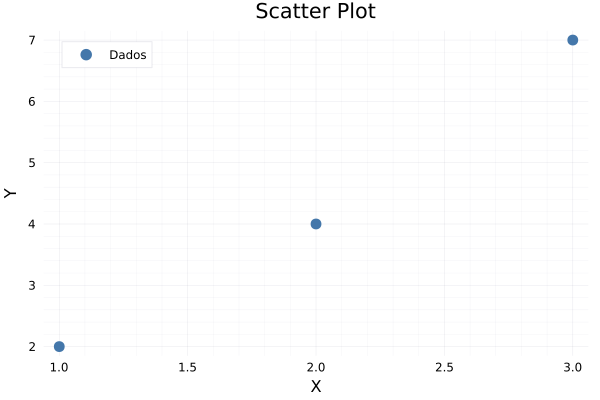

In [3]:
# Scatter plot
scatter(data.X, data.Y, label="Dados", xlabel="X", ylabel="Y", title="Scatter Plot")

In [4]:
ols = lm(@formula(Y ~ X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -0.666667    0.62361   -1.07    0.4788   -8.59038    7.25704
X             2.5         0.288675   8.66    0.0732   -1.16797    6.16797
─────────────────────────────────────────────────────────────────────────

In [5]:
round.(stderror(ols), digits=5)

2-element Vector{Float64}:
 0.62361
 0.28868

In [6]:
pred = round.(predict(ols), digits=5)

3-element Vector{Float64}:
 1.83333
 4.33333
 6.83333

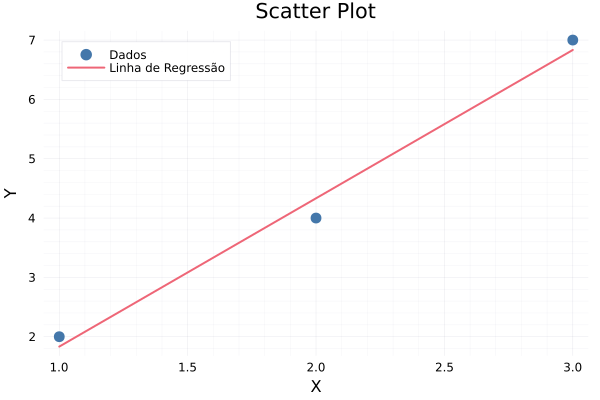

In [7]:
# Gráfico depois da regressão (com linha de regressão)
plot!(data.X, pred, label="Linha de Regressão", linewidth=2)

In [8]:
round.(confint(ols); digits=5)

2×2 Matrix{Float64}:
 -8.59038  7.25704
 -1.16797  6.16797

In [9]:
round(r2(ols); digits=5)

0.98684

In [10]:
round(adjr2(ols); digits=5)

0.97368

In [11]:
round(deviance(ols); digits=5)

0.16667

In [12]:
dof(ols)

3

In [13]:
dof_residual(ols)

1.0

In [14]:
round(aic(ols); digits=5)

5.84252

In [15]:
round(aicc(ols); digits=5)

-18.15748

In [16]:
round(bic(ols); digits=5)

3.13835

In [17]:
round(dispersion(ols.model); digits=5)

0.40825

In [18]:
round(loglikelihood(ols); digits=5)

0.07874

In [19]:
round(nullloglikelihood(ols); digits=5)

-6.41736

In [20]:
round.(vcov(ols); digits=5)

2×2 Matrix{Float64}:
  0.38889  -0.16667
 -0.16667   0.08333

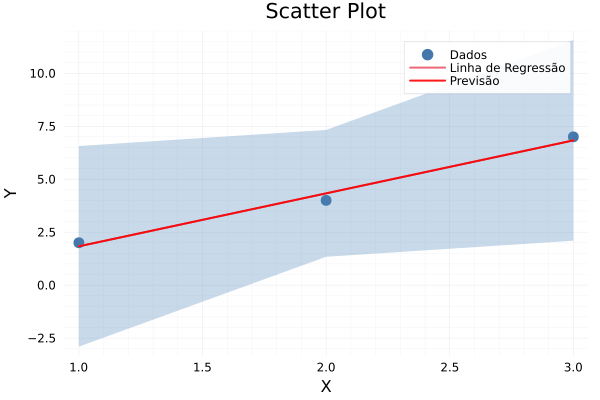

In [21]:
# Fazer previsões com intervalo de confiança
pred = predict(ols, data, interval = :confidence, level = 0.95)

# Ordenar os dados por 'x' para organizar as previsões
pred_s = pred[sortperm(data[!, :X]), :]
x_s = sort(data[!, :X])

# Adicionar a linha de previsão ao gráfico com a faixa do intervalo de confiança em cinza
plot!( x_s, pred_s.prediction, linewidth = 2, label="Previsão", xlabel="X", ylabel="Y", title="Scatter Plot",
      ribbon = (pred_s.prediction .- pred_s.lower, pred_s.upper .- pred_s.prediction), 
      fillalpha=0.3, alpha = 0.9, fillcolor=:steelblue, color=:red, formatter = :plain)

# Regressão **Probit**

In [22]:
data2 = DataFrame(X=[1,2,2], Y=[1,0,1])

Row,X,Y
,Int64,Int64
1,1,1
2,2,0
3,2,1


In [23]:
probit = glm(@formula(Y ~ X), data2, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)   9.63839     293.909   0.03    0.9738   -566.414    585.69
X            -4.81919     146.957  -0.03    0.9738   -292.849    283.211
────────────────────────────────────────────────────────────────────────

# Regressão binomial negativa (Distribuição de Pascal)
é uma distribuição de probabilidade discreta. Esta distribuição indica o número de tentativas necessárias para obter k sucessos de igual probabilidade θ ao fim de n experimentos de Bernoulli, sendo a última tentativa um sucesso.

In [24]:
using GLM, RDatasets

In [25]:
quine = dataset("MASS", "quine")

Row,Eth,Sex,Age,Lrn,Days
,Cat…,Cat…,Cat…,Cat…,Int32
1,A,M,F0,SL,2
2,A,M,F0,SL,11
3,A,M,F0,SL,14
4,A,M,F0,AL,5
5,A,M,F0,AL,5
6,A,M,F0,AL,13
7,A,M,F0,AL,20
8,A,M,F0,AL,22
9,A,M,F1,SL,6


In [26]:
nbrmodel = glm(@formula(Days ~ Eth+Sex+Age+Lrn), quine, NegativeBinomial(2.0), LogLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, NegativeBinomial{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Days ~ 1 + Eth + Sex + Age + Lrn

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   2.88645      0.227144  12.71    <1e-36   2.44125     3.33164
Eth: N       -0.567515     0.152449  -3.72    0.0002  -0.86631    -0.26872
Sex: M        0.0870771    0.159025   0.55    0.5840  -0.224606    0.398761
Age: F1      -0.445076     0.239087  -1.86    0.0627  -0.913678    0.0235251
Age: F2       0.0927999    0.234502   0.40    0.6923  -0.366816    0.552416
Age: F3       0.359485     0.246586   1.46    0.1449  -0.123814    0.842784
Lrn: SL       0.296768   

In [27]:
nbrmodel = negbin(@formula(Days ~ Eth+Sex+Age+Lrn), quine, LogLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, NegativeBinomial{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Days ~ 1 + Eth + Sex + Age + Lrn

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   2.89453      0.227415  12.73    <1e-36   2.4488      3.34025
Eth: N       -0.569341     0.152656  -3.73    0.0002  -0.868541   -0.270141
Sex: M        0.0823881    0.159209   0.52    0.6048  -0.229655    0.394431
Age: F1      -0.448464     0.238687  -1.88    0.0603  -0.916281    0.0193536
Age: F2       0.0880506    0.235149   0.37    0.7081  -0.372834    0.548935
Age: F3       0.356955     0.247228   1.44    0.1488  -0.127602    0.841513
Lrn: SL       0.292138  

In [28]:
println("Estimated theta = ", round(nbrmodel.model.rr.d.r, digits=5))

Estimated theta = 1.27489


# Regressão linear com PowerLink

A **regressão linear com powerlink** é uma variante da regressão linear onde a relação entre a variável dependente (aquela que se deseja prever) e as variáveis independentes é transformada usando uma função powerlink.

### Transformação Powerlink

A transformação powerlink generaliza a relação entre a variável dependente e as variáveis independentes, permitindo modelar diferentes tipos de relações, incluindo as não-lineares, ao invés da simples relação linear usada na regressão linear clássica.

A função powerlink é definida como:

$$
g(y) = y^\lambda
$$

onde:

- $y$ é a variável dependente,
- $\lambda$ é o parâmetro de transformação que controla o tipo de relação entre as variáveis.

### Como Funciona

- **Regressão Linear Clássica**: A regressão linear clássica assume que há uma relação linear entre as variáveis independentes e a variável dependente. Ou seja, a relação é modelada como:

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n + \epsilon
$$

- **Regressão Linear com Powerlink**: Na regressão com powerlink, essa relação é transformada de acordo com a função powerlink $g(y)$, onde a variável $Y$ (dependente) é transformada usando o parâmetro $\lambda$:

$$
g(Y) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n + \epsilon
$$

Dessa forma, a transformação não assume mais que a relação entre $Y$ e $X$'s seja puramente linear, mas sim que ela segue uma certa transformação definida pelo valor de $\lambda$.

### Interpretação do Parâmetro $\lambda$

- $\lambda = 1$: A função powerlink se reduz à identidade $g(y) = y$, que é o caso da regressão linear clássica.
- $\lambda = 0$: O modelo se aproxima de uma regressão log-linear, com $g(y) = \log(y)$.
- $\lambda$ positivo ou negativo: Controla o grau da transformação não-linear, onde diferentes valores de $\lambda$ ajustam a curvatura da relação entre as variáveis.

### Aplicações

A regressão com powerlink é útil quando:

- A relação entre as variáveis não é linear e você deseja flexibilizar o modelo.
- Há heterocedasticidade (variância não constante dos erros), que pode ser estabilizada aplicando uma transformação powerlink.
- Modelagem de dados de diferentes distribuições, como exponenciais ou outras distribuições assimétricas, que não podem ser capturadas adequadamente por uma regressão linear comum.

### Exemplos de Uso

- **Transformação Box-Cox**: Uma forma comum de aplicar a transformação powerlink é através da transformação Box-Cox, que encontra o valor ideal de $\lambda$ para estabilizar a variância e aproximar os dados de uma distribuição normal.

No pacote **GLM.jl** de Julia, você pode usar a função powerlink em modelos lineares generalizados (GLMs), que permitem modelar diferentes tipos de relações entre variáveis com maior flexibilidade em comparação com a regressão linear comum.


In [29]:
using Optim

In [30]:
trees = DataFrame(dataset("datasets", "trees"))

Row,Girth,Height,Volume
,Float64,Int64,Float64
1,8.3,70,10.3
2,8.6,65,10.3
3,8.8,63,10.2
4,10.5,72,16.4
5,10.7,81,18.8
6,10.8,83,19.7
7,11.0,66,15.6
8,11.0,75,18.2
9,11.1,80,22.6


In [31]:
bic_glm(λ) = bic(glm(@formula(Volume ~ Height + Girth), trees, Normal(), PowerLink(λ)));

In [32]:
optimal_bic = optimize(bic_glm, -1.0, 1.0);

In [33]:
round(optimal_bic.minimizer, digits = 5) # Optimal λ

0.40935

In [34]:
glm(@formula(Volume ~ Height + Girth), trees, Normal(), PowerLink(optimal_bic.minimizer)) # Best model

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Normal{Float64}, PowerLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Volume ~ 1 + Height + Girth

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  -1.07586    0.352543    -3.05    0.0023  -1.76684    -0.384892
Height        0.0232172  0.00523331   4.44    <1e-05   0.0129601   0.0334743
Girth         0.242837   0.00922555  26.32    <1e-99   0.224756    0.260919
────────────────────────────────────────────────────────────────────────────

In [35]:
round(optimal_bic.minimum, digits=5)

156.37638

# Outros Exemplos

### Exemplo 1

In [36]:
form = dataset("datasets", "Formaldehyde")

Row,Carb,OptDen
,Float64,Float64
1,0.1,0.086
2,0.3,0.269
3,0.5,0.446
4,0.6,0.538
5,0.7,0.626
6,0.9,0.782


In [37]:
lm1 = fit(LinearModel, @formula(OptDen ~ Carb), form)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

OptDen ~ 1 + Carb

Coefficients:
───────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  0.00508571  0.00783368   0.65    0.5516  -0.0166641  0.0268355
Carb         0.876286    0.0135345   64.74    <1e-06   0.838708   0.913864
───────────────────────────────────────────────────────────────────────────

### Exemplo 2

In [38]:
LifeCycleSavings = dataset("datasets", "LifeCycleSavings")

Row,Country,SR,Pop15,Pop75,DPI,DDPI
,String15,Float64,Float64,Float64,Float64,Float64
1,Australia,11.43,29.35,2.87,2329.68,2.87
2,Austria,12.07,23.32,4.41,1507.99,3.93
3,Belgium,13.17,23.8,4.43,2108.47,3.82
4,Bolivia,5.75,41.89,1.67,189.13,0.22
5,Brazil,12.88,42.19,0.83,728.47,4.56
6,Canada,8.79,31.72,2.85,2982.88,2.43
7,Chile,0.6,39.74,1.34,662.86,2.67
8,China,11.9,44.75,0.67,289.52,6.51
9,Colombia,4.98,46.64,1.06,276.65,3.08


In [39]:
fm2 = fit(LinearModel, @formula(SR ~ Pop15 + Pop75 + DPI + DDPI), LifeCycleSavings)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

SR ~ 1 + Pop15 + Pop75 + DPI + DDPI

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                    Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  28.5661       7.35452       3.88    0.0003  13.7533      43.3788
Pop15        -0.461193     0.144642     -3.19    0.0026  -0.752518    -0.169869
Pop75        -1.6915       1.0836       -1.56    0.1255  -3.87398      0.490983
DPI          -0.000336902  0.000931107  -0.36    0.7192  -0.00221225   0.00153844
DDPI          0.409695     0.196197      2.09    0.0425   0.0145336    0.804856
─────────────────────────────────────────────────────────────────────────────────

### Exemplo 3

In [40]:
using CategoricalArrays

In [41]:
dobson = DataFrame(Counts    = [18.,17,15,20,10,21,25,13,13],
                          Outcome   = categorical([1,2,3,1,2,3,1,2,3]),
                          Treatment = categorical([1,1,1,2,2,2,3,3,3]))

Row,Counts,Outcome,Treatment
,Float64,Cat…,Cat…
1,18.0,1,1
2,17.0,2,1
3,15.0,3,1
4,20.0,1,2
5,10.0,2,2
6,21.0,3,2
7,25.0,1,3
8,13.0,2,3
9,13.0,3,3


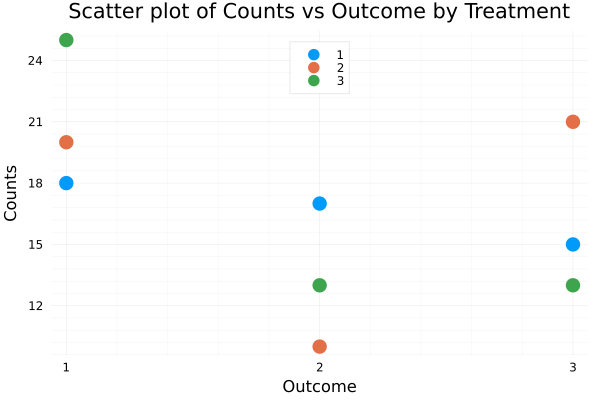

In [42]:
# Plotando o gráfico de dispersão
scatter(dobson.Outcome, dobson.Counts, group=dobson.Treatment, 
    xlabel="Outcome", ylabel="Counts", 
    title="Scatter plot of Counts vs Outcome by Treatment",
    legend=:top, markersize=8, palette=:auto)

In [43]:
gm1 = fit(GeneralizedLinearModel, @formula(Counts ~ Outcome + Treatment), dobson, Poisson())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Counts ~ 1 + Outcome + Treatment

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.03128      0.171155  17.71    <1e-69   2.69582    3.36674
Outcome: 2    -0.454255     0.202171  -2.25    0.0246  -0.850503  -0.0580079
Outcome: 3    -0.251314     0.190476  -1.32    0.1870  -0.624641   0.122012
Treatment: 2   0.0198026    0.199017   0.10    0.9207  -0.370264   0.409869
Treatment: 3   0.0198026    0.199017   0.10    0.9207  -0.370264   0.409869
────────────────────────────────────────────────────────────────────────────

In [44]:
round(deviance(gm1), digits=5)

5.11746

In [45]:
# Obtendo os valores ajustados (fitted values)
fitted_values = predict(gm1)

9-element Vector{Float64}:
 20.72368421052631
 13.15789473684212
 16.118421052631582
 21.138157894736846
 13.421052631578968
 16.44078947368422
 21.13815789473684
 13.421052631578963
 16.440789473684212

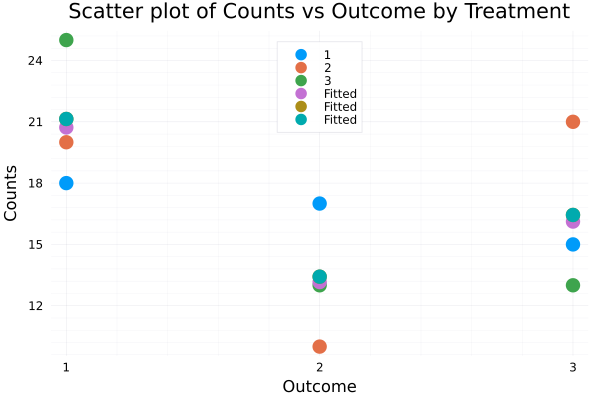

In [46]:
# Adicionando os valores ajustados ao gráfico
scatter!(dobson.Outcome, fitted_values, group=dobson.Treatment, 
    markershape=:circle, label="Fitted", markersize=8, palette=:auto)

# **Flux**.jl

Flux é um stack de aprendizado de máquina puramente em Julia que permite criar modelos preditivos. Aqui estão as etapas para um programa típico usando Flux:

1. **Fornecer dados de treinamento e teste**
2. **Construir um modelo com parâmetros configuráveis para fazer previsões**
3. **Treinar iterativamente o modelo ajustando os parâmetros para melhorar as previsões**
4. **Verificar o seu modelo**

Por baixo dos panos, Flux utiliza uma técnica chamada diferenciação automática para calcular gradientes que ajudam a melhorar as previsões. Flux também é totalmente escrito em Julia, o que permite substituir facilmente qualquer camada do Flux com seu próprio código para melhorar sua compreensão ou atender a requisitos especiais.

A página a seguir contém um passo a passo do algoritmo de regressão linear em Julia usando Flux! Vamos começar criando um modelo simples de regressão linear para dados fictícios e depois passar para um conjunto de dados real. A primeira parte envolverá escrever algumas partes do modelo por conta própria, que mais tarde serão substituídas pelo Flux.

Vamos começar construindo um modelo simples de regressão linear. Este modelo será treinado com os pontos de dados na forma `(x₁, y₁), (x₂, y₂), ... , (xₙ, yₙ)`. No mundo real, esses xs podem ter múltiplas características, e os ys denotam um rótulo. No nosso exemplo, cada x tem uma única característica; portanto, nossos dados terão n pontos de dados, com cada ponto mapeando uma única característica para um único rótulo.

https://fluxml.ai/Flux.jl/stable/tutorials/linear_regression/#Gathering-real-data

In [101]:
using Flux, Plots

> Gerando um conjunto de dados

Os dados geralmente vêm do mundo real, que exploraremos na última parte deste tutorial, mas não queremos pular diretamente para a parte relativamente mais difícil. Aqui, vamos gerar os xs dos nossos pontos de dados e mapeá-los para os respectivos ys usando uma função simples. Lembre-se de que, aqui, cada x é equivalente a uma característica, e cada y é o rótulo correspondente. Ao combinar todos os xs e ys, teremos o conjunto de dados completo.


In [103]:
x = hcat(collect(Float32, -3:0.1:3)...)

1×61 Matrix{Float32}:
 -3.0  -2.9  -2.8  -2.7  -2.6  -2.5  …  2.4  2.5  2.6  2.7  2.8  2.9  3.0

A chamada `hcat` gera uma `matriz` com números variando de `-3.0` a `3.0`, com um intervalo de 0.1 entre eles. Cada coluna dessa matriz contém um único x, totalizando 61 xs. O próximo passo seria gerar os rótulos correspondentes, ou os ys.


In [104]:
f(x) = @. 3x + 2

f (generic function with 1 method)

In [105]:
y = f(x)

1×61 Matrix{Float32}:
 -7.0  -6.7  -6.4  -6.1  -5.8  -5.5  …  9.5  9.8  10.1  10.4  10.7  11.0

A função `f` mapeia cada x para um y, e como x é uma matriz, a expressão transmite os valores escalares usando a macro `@.`. Nossos pontos de dados estão prontos, mas estão perfeitos demais. Em um cenário do mundo real, não teríamos uma função `f` para gerar os valores de y, mas, em vez disso, os rótulos seriam adicionados manualmente.


In [107]:
x = x .* reshape(rand(Float32, 61), (1, 61))

1×61 Matrix{Float32}:
 -2.39464  -0.712576  -0.966622  -0.782411  …  0.0704534  0.292649  0.643481

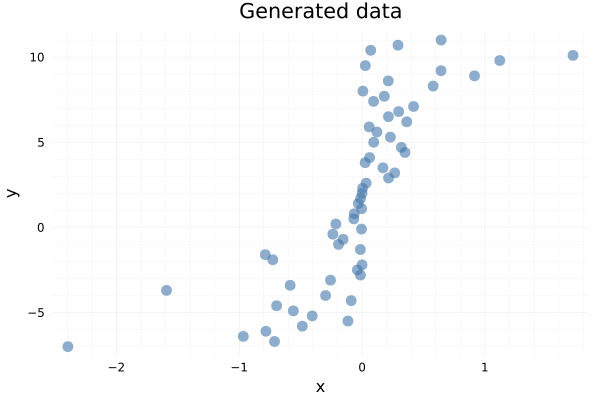

In [108]:
plot(vec(x), vec(y), lw = 3, seriestype = :scatter, alpha = 0.6, label = "", title = "Generated data", xlabel = "x", ylabel= "y")

Agora os dados parecem suficientemente aleatórios! Os valores de x e y ainda estão um pouco correlacionados; portanto, o algoritmo de regressão linear deve funcionar bem no nosso conjunto de dados.

Agora podemos prosseguir e construir um modelo para o nosso conjunto de dados!


# Construindo um modelo

Um modelo de regressão linear é definido matematicamente como:

$$
model(W, b, x) = Wx + b
$$

onde **W** é a matriz de pesos e **b** é o viés. Para o nosso caso, a matriz de pesos (W) conterá apenas um único elemento, pois temos apenas uma característica. Podemos definir nosso modelo em Julia usando a mesma notação exata!


In [109]:
custom_model(W, b, x) = @. W*x + b

custom_model (generic function with 1 method)

A macro `@.` permite realizar os cálculos transmitindo as quantidades escalares (por exemplo, o viés).

O próximo passo seria inicializar os parâmetros do modelo, que são o peso e o viés. Existem muitas técnicas de inicialização disponíveis para diferentes modelos de aprendizado de máquina, mas, para este exemplo, vamos retirar o peso de uma distribuição uniforme e inicializar o viés como 0.


In [110]:
W = rand(Float32, 1, 1)

1×1 Matrix{Float32}:
 0.039499402

In [111]:
b = [0.0f0]

1-element Vector{Float32}:
 0.0

Hora de testar se o nosso modelo funciona!


In [113]:
custom_model(W, b, x) |> size

(1, 61)

In [114]:
custom_model(W, b, x)[1], y[1]

(-0.094587035f0, -7.0f0)

Funciona! Mas as previsões estão bem distantes. Precisamos treinar o modelo para melhorar as previsões, mas antes de treinar o modelo, precisamos definir a função de perda. A função de perda deve idealmente gerar uma quantidade que tentaremos minimizar durante todo o processo de treinamento. Aqui, usaremos a função de perda de erro quadrático médio (mean squared error).


In [115]:
function custom_loss(weights, biases, features, labels)
    ŷ = custom_model(weights, biases, features)
    sum((labels .- ŷ).^2) / length(features)
end;

In [116]:
custom_loss(W, b, x, y)

31.723724f0

Chamar a função de perda nos nossos xs e ys mostra o quanto nossas previsões (ŷ) estão distantes dos rótulos reais. Mais precisamente, ela calcula a soma dos quadrados dos resíduos e divide pelo número total de pontos de dados.

Nós definimos com sucesso nosso modelo e a função de perda, mas surpreendentemente, ainda não usamos o Flux em nenhum lugar até agora. Vamos ver como podemos escrever o mesmo código usando o Flux.


In [117]:
flux_model = Dense(1 => 1)

Dense(1 => 1)       # 2 parameters

Uma camada `Dense(1 => 1)` denota uma camada com um neurônio, um input (uma característica) e uma saída. Esta camada é exatamente igual ao modelo matemático que definimos acima! Nos bastidores, o Flux também calcula a saída usando a mesma expressão! Mas, desta vez, não precisamos inicializar os parâmetros nós mesmos, em vez disso, o Flux faz isso para nós.


In [118]:
flux_model.weight, flux_model.bias

(Float32[0.422228;;], Float32[0.0])

Agora podemos verificar se o nosso modelo está funcionando corretamente. Podemos passar todos os dados de uma vez, com cada x tendo exatamente uma característica (um input) -


In [119]:
flux_model(x) |> size

(1, 61)

In [120]:
flux_model(x)[1], y[1]

(-1.0110861f0, -7.0f0)

Está funcionando! O próximo passo seria definir a função de perda utilizando as funções do Flux -


In [121]:
function flux_loss(flux_model, features, labels)
    ŷ = flux_model(features)
    Flux.mse(ŷ, labels)
end;

In [122]:
flux_loss(flux_model, x, y)

30.07039f0

Tudo funciona como antes! Quase parece que o Flux nos fornece "envoltórios inteligentes" para as funções que poderíamos ter escrito por conta própria. Agora, como último passo desta seção, vamos ver o quão diferente o `flux_model` é do nosso `custom_model`. Uma boa maneira de fazer isso seria fixar os parâmetros de ambos os modelos para que sejam os mesmos. Vamos alterar os parâmetros do nosso `custom_model` para coincidir com os do `flux_model` -


In [123]:
W = Float32[1.1412252]

1-element Vector{Float32}:
 1.1412252

Para verificar como ambos os modelos estão se saindo com os dados, vamos descobrir as perdas usando as funções `loss` e `flux_loss` -


In [124]:
custom_loss(W, b, x, y), flux_loss(flux_model, x, y)

(27.232512f0, 30.07039f0)

As perdas são idênticas! Isso significa que nosso modelo e o `flux_model` são idênticos em algum nível, e as funções de perda são completamente idênticas! A diferença entre os modelos é que a camada `Dense` do Flux suporta muitos outros argumentos que podem ser usados para personalizar a camada ainda mais. Mas, para este tutorial, vamos manter nosso simples `custom_model`.


Treinando o modelo
Vamos treinar nosso modelo usando o clássico algoritmo de Gradiente Descendente. De acordo com o algoritmo de gradiente descendente, os pesos e os vieses devem ser iterativamente atualizados usando as seguintes equações matemáticas:

$$W = W − η * dL/dW$$  
$$b = b − η * dL/db$$  

Onde:
- $W$ é a matriz de pesos,
- $b$ é o vetor de vieses,
- $η$ é a taxa de aprendizado,
- $dL/dW$ é a derivada da função de perda em relação ao peso, e
- $dL/db$ é a derivada da função de perda em relação ao viés.

As derivadas são calculadas usando uma ferramenta de Diferenciação Automática, e o Flux usa o Zygote.jl para isso. Como o Zygote.jl é um pacote independente do Julia, ele pode ser usado fora do Flux também! Consulte a documentação do Zygote.jl para mais informações sobre o mesmo.

Nosso primeiro passo seria obter o gradiente da função de perda em relação aos pesos e aos vieses. O Flux reexporta a função de gradiente do Zygote, portanto, não precisamos importar o Zygote explicitamente para usar essa funcionalidade.


In [67]:
dLdW, dLdb, _, _ = gradient(custom_loss, W, b, x, y);

Agora podemos atualizar os parâmetros, seguindo o algoritmo de gradiente descendente -


In [68]:
W .= W .- 0.1 .* dLdW

1-element Vector{Float32}:
 1.85454

In [69]:
b .= b .- 0.1 .* dLdb

1-element Vector{Float32}:
 0.38598934

Os parâmetros foram atualizados! Agora podemos verificar o valor da função de perda -


In [70]:
custom_loss(W, b, x, y)

16.493235f0

A perda diminuiu! Isso significa que treinamos com sucesso nosso modelo por uma época. Podemos colocar o código de treinamento escrito acima em um loop e treinar o modelo por um número maior de épocas. Ele pode ser personalizado para ter um número fixo de épocas ou parar quando certas condições forem atendidas, por exemplo, quando a mudança na perda for < 0,1. O loop pode ser ajustado para atender às necessidades do usuário, e as condições podem ser especificadas em Julia!

Vamos colocar nossa super lógica de treinamento dentro de uma função e testar novamente -


In [71]:
function train_custom_model!(f_loss, weights, biases, features, labels)
    dLdW, dLdb, _, _ = gradient(f_loss, weights, biases, features, labels)
    @. weights = weights - 0.1 * dLdW
    @. biases = biases - 0.1 * dLdb
end;

In [72]:
train_custom_model!(custom_loss, W, b, x, y);

In [73]:
W, b, custom_loss(W, b, x, y)

(Float32[2.4065409], Float32[0.6860236], 12.990754f0)

Funciona, e a perda diminuiu novamente! Esta foi a segunda época do nosso procedimento de treinamento. Vamos colocar isso em um loop `for` e treinar o modelo por 30 épocas.



In [74]:
for i = 1:40
    train_custom_model!(custom_loss, W, b, x, y)
 end

In [75]:
W, b, custom_loss(W, b, x, y)

(Float32[4.2937126], Float32[1.7363762], 7.7350483f0)

Houve uma redução significativa na perda, e os parâmetros foram atualizados!

Podemos treinar o modelo ainda mais ou ajustar os hiperparâmetros para alcançar o resultado desejado mais rapidamente, mas vamos parar por aqui. Treinamos nosso modelo por 42 épocas, e a perda diminuiu de 22.74856 para 7.6680417f. Hora de visualizar!


## Resultados
O objetivo principal deste tutorial era ajustar uma linha ao nosso conjunto de dados usando o algoritmo de regressão linear. O procedimento de treinamento correu bem, e a perda diminuiu significativamente! Vamos ver como fica a linha ajustada. Lembre-se, Wx + b nada mais é do que a equação de uma linha, com inclinação = W[1] e intercepto no eixo y = b[1] (indexando a partir de 1, pois W e b são iteráveis).

Plotando a linha e os pontos de dados usando o Plot.jl -


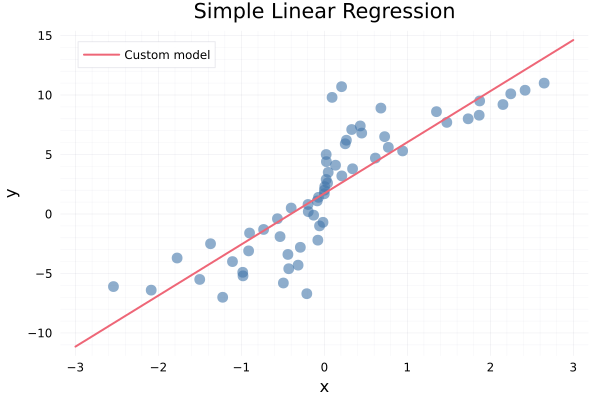

In [76]:
# Plot scatter plot
plot(reshape(x, (61, 1)), reshape(y, (61, 1)), lw = 3, seriestype = :scatter, alpha = 0.6, label = "", title = "Simple Linear Regression", xlabel = "x", ylabel = "y")

# Plot custom model line
plot!((x) -> b[1] + W[1] * x, -3, 3, label="Custom model", lw=2)

A linha se ajusta bem! Há espaço para melhorias, mas deixamos isso por sua conta! Você pode brincar com os otimizadores, o número de épocas, a taxa de aprendizado, etc., para melhorar o ajuste e reduzir a perda!


## Modelo de Regressão Linear em um Conjunto de Dados Real

Agora, vamos para um modelo de regressão linear relativamente mais complexo. Aqui, usaremos um conjunto de dados real do pacote MLDatasets.jl, que não restringirá nossos pontos de dados a ter apenas uma característica. Vamos começar importando os pacotes necessários -


In [125]:
using Statistics, MLDatasets, Flux

## Coletando Dados Reais

Vamos começar inicializando nosso conjunto de dados. Usaremos o conjunto de dados BostonHousing, que consiste em 506 pontos de dados. Cada um desses pontos de dados tem 13 características e um rótulo correspondente, o preço da casa. Os xs ainda são mapeados para um único y, mas agora, um único ponto de dados x tem 13 características.


In [126]:
df = BostonHousing()

dataset BostonHousing:
  metadata   =>    Dict{String, Any} with 5 entries
  features   =>    506×13 DataFrame
  targets    =>    506×1 DataFrame
  dataframe  =>    506×14 DataFrame

In [127]:
x, y = BostonHousing(as_df=false)[:]

(features = [0.00632 0.02731 … 0.10959 0.04741; 18.0 0.0 … 0.0 0.0; … ; 396.9 396.9 … 393.45 396.9; 4.98 9.14 … 6.48 7.88], targets = [24.0 21.6 … 22.0 11.9])

In [128]:
x, y = Float32.(x), Float32.(y)

(Float32[0.00632 0.02731 … 0.10959 0.04741; 18.0 0.0 … 0.0 0.0; … ; 396.9 396.9 … 393.45 396.9; 4.98 9.14 … 6.48 7.88], Float32[24.0 21.6 … 22.0 11.9])

Agora podemos dividir os dados obtidos em dados de treinamento e teste.


In [129]:
x_train, x_test, y_train, y_test = x[:, 1:400], x[:, 401:end], y[:, 1:400], y[:, 401:end]

(Float32[0.00632 0.02731 … 38.3518 9.91655; 18.0 0.0 … 0.0 0.0; … ; 396.9 396.9 … 396.9 338.16; 4.98 9.14 … 30.59 29.97], Float32[25.0461 14.2362 … 0.10959 0.04741; 0.0 0.0 … 0.0 0.0; … ; 396.9 396.9 … 393.45 396.9; 26.77 20.32 … 6.48 7.88], Float32[24.0 21.6 … 5.0 6.3], Float32[5.6 7.2 … 22.0 11.9])

In [130]:
x_train |> size, x_test |> size, y_train |> size, y_test |> size

((13, 400), (13, 106), (1, 400), (1, 106))

Esses dados contêm um número diverso de características, o que significa que as características possuem escalas diferentes. Uma opção sensata aqui seria normalizar os dados, tornando o processo de treinamento mais eficiente e rápido. Vamos verificar o desvio padrão dos dados de treinamento antes de normalizá-los.


In [131]:
std(x_train)

134.06784f0

Os dados realmente não estão normalizados. Podemos usar a função `Flux.normalise` para normalizar os dados de treinamento.


In [132]:
x_train_n = Flux.normalise(x_train)

13×400 Matrix{Float32}:
 -0.291714   -0.288204   -0.288208   …   0.990111   6.12025    1.36543
  0.142908   -0.566704   -0.566704      -0.566704  -0.566704  -0.566704
 -1.09268    -0.360778   -0.360778       1.33521    1.33521    1.33521
 -0.309651   -0.309651   -0.309651      -0.309651  -0.309651  -0.309651
  0.0692556  -0.53714    -0.53714        1.43145    1.43145    1.43145
  0.325826    0.115675    1.15825    …  -0.80408   -1.20528   -0.660795
  0.0386202   0.511778   -0.102982       1.20252    1.24051    0.473787
 -0.0504443   0.352901    0.352901      -1.18014   -1.24627   -1.2413
 -0.892326   -0.733479   -0.733479       2.76117    2.76117    2.76117
 -0.419361   -0.840437   -0.840437       2.46579    2.46579    2.46579
 -1.21946    -0.0922191  -0.0922191  …   0.989937   0.989937   0.989937
  0.419404    0.419404    0.31926        0.325904   0.419404  -1.02591
 -0.927326   -0.312123   -1.06782        1.28208    2.86002    2.76833

In [133]:
std(x_train_n)

1.0000843f0

A desviacão padrão agora está próxima de um! Nossos dados estão prontos!


## Construindo um modelo Flux
Agora podemos usar diretamente o Flux e deixar que ele faça todo o trabalho internamente! Vamos definir um modelo que recebe 13 entradas (13 características) e nos dá uma única saída (o rótulo). Em seguida, passaremos todos os nossos dados por este modelo de uma vez, e o Flux cuidará de tudo para nós! Lembre-se de que também poderíamos ter declarado um modelo em Julia puro. O modelo terá 14 parâmetros: 13 pesos e 1 viés.


In [138]:
model = Dense(13 => 1)

Dense(13 => 1)      # 14 parameters

Assim como antes, nosso próximo passo seria definir uma função de perda para quantificar nossa precisão de alguma forma. Quanto menor a perda, melhor o modelo!


In [139]:
function loss(model, features, labels)
    ŷ = model(features)
    Flux.mse(ŷ, labels)
end

loss (generic function with 1 method)

In [140]:
loss(model, x_train_n, y_train)

674.0075f0

Agora podemos prosseguir para a fase de treinamento!









## Treinando o modelo Flux
O procedimento de treinamento utilizaria a mesma matemática, mas agora podemos passar o modelo dentro da chamada do gradiente e deixar o Flux e o Zygote lidarem com as derivadas!

In [141]:
function train_model!(f_loss, model, features, labels)
    dLdm, _, _ = gradient(f_loss, model, features, labels)
    @. model.weight = model.weight - 0.000001 * dLdm.weight
    @. model.bias = model.bias - 0.000001 * dLdm.bias
end

train_model! (generic function with 1 method)

Ao contrário do nosso último procedimento de treinamento, digamos que desta vez não queremos definir o número de épocas de forma fixa. Queremos que o procedimento de treinamento pare quando a perda convergir, ou seja, quando a mudança na perda for < δ. A quantidade δ pode ser alterada conforme a necessidade do usuário, mas vamos fixá-la em 10⁻³ para este tutorial.

Podemos escrever esses loops de treinamento personalizados de forma simples usando o Flux e o Julia puro!

In [142]:
loss_init = Inf

Inf

In [143]:
while true
    train_model!(loss, model, x_train_n, y_train)
    if loss_init == Inf
        loss_init = loss(model, x_train_n, y_train)
        continue
    end
    if abs(loss_init - loss(model, x_train_n, y_train)) < 1e-4
        break
    else
        loss_init = loss(model, x_train_n, y_train)
    end
end

O código começa inicializando um valor inicial para a perda, que é infinito. Em seguida, ele executa um loop infinito que é interrompido se a mudança na perda for < 10⁻³, ou o código altera o valor de `loss_init` para a perda atual e passa para a próxima iteração.

Esse loop personalizado funciona! Isso demonstra como é fácil para o usuário escrever qualquer rotina de treinamento personalizada usando Flux e Julia!

Agora, vamos dar uma olhada na perda.









In [145]:
loss(model, x_train_n, y_train)

52.670265f0

A perda diminuiu significativamente! Ela pode ser minimizada ainda mais escolhendo um valor de δ menor.

## Testando o modelo Flux
O último passo deste tutorial será testar nosso modelo usando os dados de teste. Primeiro, vamos normalizar os dados de teste e depois calcular a perda correspondente.

In [146]:
x_test_n = Flux.normalise(x_test);

In [147]:
loss(model, x_test_n, y_test)

35.13194f0

A perda não é tão pequena quanto a perda dos dados de treinamento, mas está boa! Isso também mostra que nosso modelo não está sobreajustando (overfitting)!

Resumindo este tutorial, começamos gerando um conjunto de dados aleatório, mas correlacionado, para o nosso modelo personalizado. Em seguida, vimos como um modelo simples de regressão linear poderia ser construído com e sem Flux, e como eles eram quase idênticos.

Depois, treinamos o modelo escrevendo manualmente o algoritmo de Gradiente Descendente e otimizando a perda. Também vimos como o Flux oferece várias funcionalidades de wrapper e mantém a API extremamente intuitiva e simples para os usuários.

Após nos familiarizarmos com os fundamentos do Flux e do Julia, avançamos para construir um modelo de aprendizado de máquina para um conjunto de dados real. Repetimos exatamente os mesmos passos, mas desta vez com muito mais recursos e pontos de dados, aproveitando ao máximo as capacidades do Flux. No final, desenvolvemos um loop de treinamento mais inteligente do que o codificado manualmente e executamos o modelo em nosso conjunto de dados normalizado para concluir o tutorial.